In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation
from seaborn import heatmap, color_palette
from scipy import sparse




# Utility Functions

In [2]:
def show_matrice(W, ax = None):
    %matplotlib inline
    fig = plt.figure(figsize=(9,7))
    map = heatmap(W.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax)

In [3]:
def show_ei_matrix(Wee, Wei, Wie):
    plt.figure(figsize=(7,7))

    ax0 = plt.subplot2grid((n_e+n_i, n_e+n_i), (0, 0), colspan=n_i, rowspan=n_e)
    ax0.imshow(Wie.A, cmap=color_palette("vlag", as_cmap=True))
    ax0.axis('off')

    ax1 = plt.subplot2grid((n_e+n_i, n_e+n_i), (0, n_i), colspan=n_e, rowspan=n_e)
    ax1.imshow(Wee.A, cmap=color_palette("vlag", as_cmap=True))
    ax1.axis('off')

    ax2 = plt.subplot2grid((n_e+n_i, n_e+n_i), (n_e, 0), colspan=n_i, rowspan=n_i)
    ax2.imshow(np.zeros((n_i, n_i)), cmap=color_palette("vlag", as_cmap=True))
    ax2.axis('off')

    ax3 = plt.subplot2grid((n_e+n_i, n_e+n_i), (n_e, n_i), colspan=n_e, rowspan=n_i)
    ax3.imshow(Wei.toarray(), cmap=color_palette("vlag", as_cmap=True))
    ax3.axis('off')

    plt.show()

# Reservoir functions

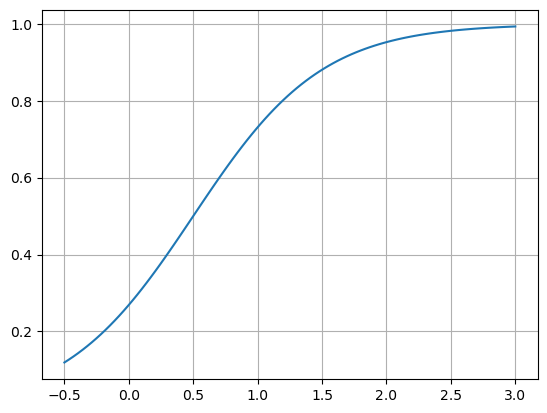

In [4]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment

activation_function = lambda x : sigmoid(2*(x-0.5))

plt.plot(np.linspace(-0.5, 3, 100), activation_function(np.linspace(-0.5, 3, 100)))
plt.grid()

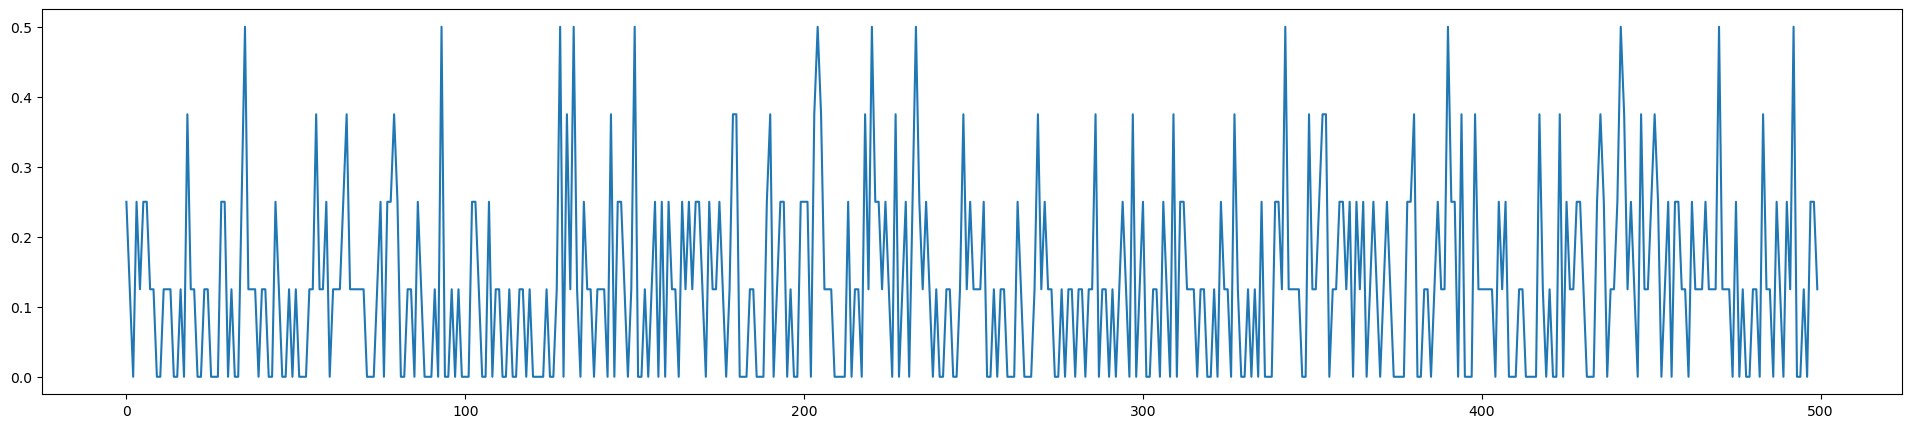

In [5]:
from scipy.stats import poisson

mu = 1
timesteps = 100000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(500), U_train1[10000:10500])
plt.show()

# Simulation
https://www.nature.com/articles/s41598-018-22077-3#Fig1

In [6]:
from importlib import reload
import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion, add_activity_connexion_for_excitatory, select_pairs_connexion, select_pairs_pruning, change_connexion
reload(connexion_generation.activity_dependant_connexion)

<module 'connexion_generation.activity_dependant_connexion' from '/home/idlab278/Code/structural_plasticity/adsp/connexion_generation/activity_dependant_connexion.py'>

In [7]:
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

In [8]:
# Parameters
n_e = 50 # number of neurons for excitatory pool
n_i = 20 # number of neurons for inhibitory pool
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075

# HYPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 0.6


# Initialisation EE
Win_ee, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_ee = Win_ee*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, spectral_radius, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

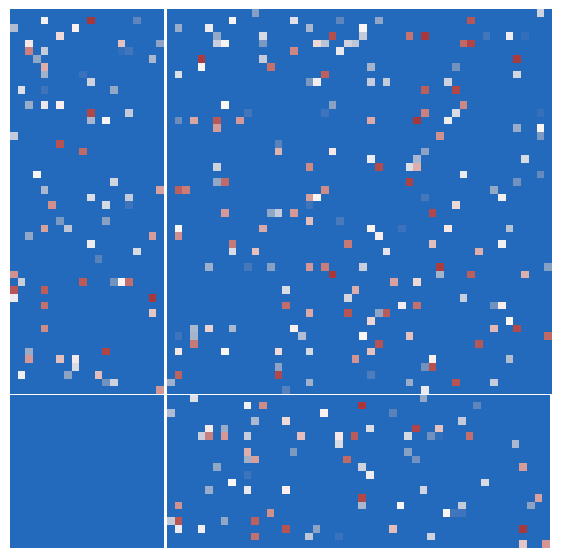

In [9]:
show_ei_matrix(W_ee, W_ei, W_ie)

In [10]:
# Parameters
# The parameters you want to see the influence

import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion, add_activity_connexion_for_excitatory, select_pairs_connexion, select_pairs_pruning, change_connexion
reload(connexion_generation.activity_dependant_connexion)

growth_parameter = 0.1
target_rate=0.7

# Initialisation
W_ee_adsp = W_ee.copy()
W_ie_adsp = W_ie.copy()
W_ei_adsp = W_ei.copy()
U_train3 = U_train1.copy()
state_e = last_state_e
state_i = last_state_i

train_length = len(U_train3)
step=0
convergence_step = 0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
state_history_i = []
delta_z_e_history = []
delta_z_i_history = []

for i in range(INCREMENT*5):
    state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    state_history_e.append(state_e)
    state_history_i.append(state_i)
U_train3 = U_train3[INCREMENT*5:]
train_length = len(U_train3)

while total_add + total_prun < 5000 and train_length > 5000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

    # For excitatory neurons
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_e_history.append(delta_z_e)
    # Plasticity for both We and Wie
    W_ee_adsp, W_ie_adsp, nb_new_add_e, nb_new_prun_e = add_activity_connexion_for_excitatory(W_ee_adsp, W_ie_adsp, state_e, delta_z_e, VALUE)
    # Only Wee plasticity
    # W_ee_adsp, nb_new_add, nb_new_prun = add_activity_connexion(W_ee_adsp, state_e, delta_z_e, VALUE)
    
    # For inhibitory neurons
    delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_i_history.append(delta_z_i)
    W_ei_adsp, nb_new_add_i, nb_new_prun_i = add_activity_connexion(W_ei_adsp, state_i, delta_z_i, VALUE)
 
    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        state_history_i.append(state_i)
        
    U_train3 = U_train3[INCREMENT:]
    train_length = len(U_train3)
    length = len(U_train3)
    total_add += nb_new_add_e + nb_new_add_i
    total_prun += nb_new_prun_e + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    if step > 5 and convergence_step == 0:
        mean_add = (add[-1]-add[-5])/2
        mean_prun = (prun[-1]-prun[-5])/2
        if prun[3] > add[3] and mean_add >= mean_prun: 
            convergence_step = step
        if prun[3] < add[3] and mean_add <= mean_prun: 
            convergence_step = step
    step +=1
add = np.array(add)
prun = np.array(prun)

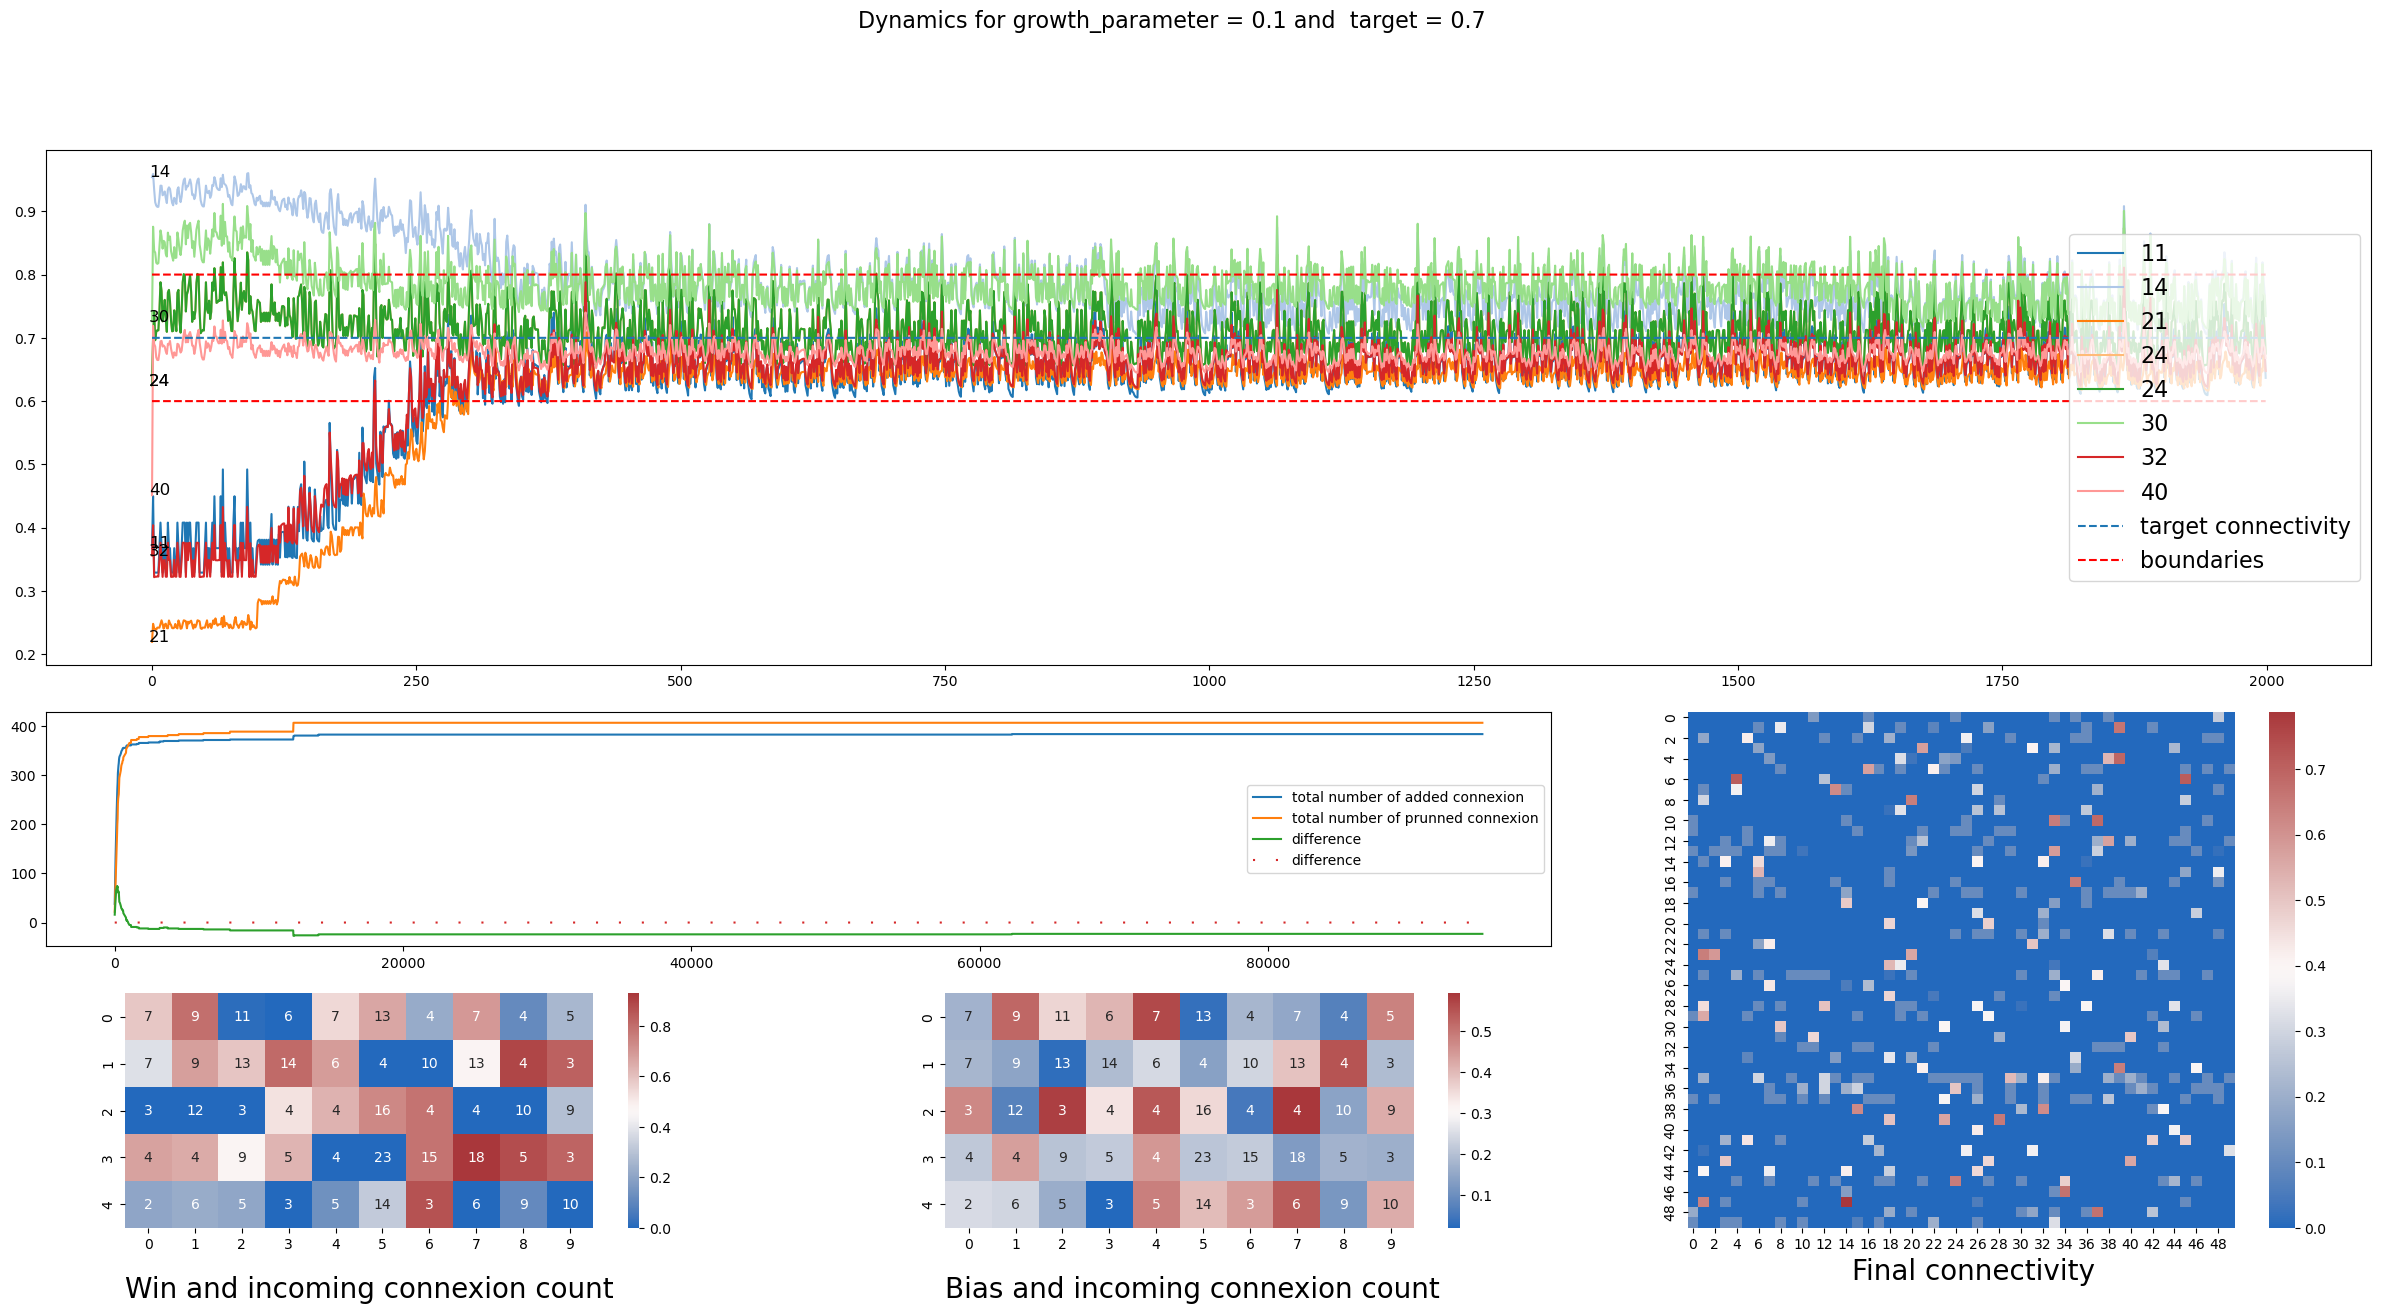

In [11]:
from math import copysign

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")

# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 2000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(step*INCREMENT)[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)), label="difference")
ax1.legend()

ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,55, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
heatmap(Win_ee.A.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax3)
ax3.text(0, 6.5, 'Win and incoming connexion count',fontsize=20)

ax4 = plt.subplot2grid((4, 3), (3, 1))
heatmap(bias_e.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax4)
ax4.text(0, 6.5, 'Bias and incoming connexion count',fontsize=20)

plt.show()

# Measurement

## Richness in reservoir
https://arxiv.org/pdf/1903.05174.pdf

### Memory capacity

In [ ]:
import Capacities.capacities as CAP

state_history_e = np.array(state_history_e)
inputs = U_train1[:state_history_e.shape[0],:]
# Measure capacities on inputs and states after removing a "warmup period"
# If you require more extensive printed output of individual capacities:
# set verbose = 1
Citer=CAP.capacity_iterator()#, verbose = 1)
totalcap,allcaps,numcaps,nodes = Citer.collect(inputs,state_history_e)

print("\nMeasured ",numcaps," capacities above threshold.\nTotal capacity = ",totalcap)


Estimated rank of state covariance matrix =  50
Total score for degree  1  =  6.088945542663499 (cumulative total =  6.088945542663499 )


In [ ]:
state_history_e.shape

### Uncoupled dynamics

In [ ]:
def compute_state_history(W_ee, W_ie, W_ei, Win, U, state_e, state_i, bias_e, bias_i, activation_function, leaky_rate = 1, temp = 5000, A= 0.9):
    ST = []
    if state_e is None:
        state_e = np.random.uniform(-1, 1, n)
    if state_i is None:
        state_i = np.random.uniform(-1, 1, n)

    state_history_e.append(state)
    state_history_i.append(state)

    for i in range(temp):
        state_e, state_i = update_ei_reservoir(W_ee, W_ie, W_ei, Win, U[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        state_history_i.append(state_i)
    U_train3 = U_train3[1:]
    
    return state_history_e, state_history_i
  
def uncoupled_dynamics(STATE_H, temp = 5000, A= 0.9):
    # A : in (0, 1] and expresses the desired amount of explained variability
    # temps : int, the number of steps we want to evaluate the dynamics on
    STATE_H = np.array(STATE_H)
    
    # compute the (sorted) singular values and the poucentage wise singular values
    _, singular_values, _ = np.linalg.svd(STATE_H)
    rel_sv = []
    for s in singular_values:
        rel_sv.append(s / np.sum(singular_values))

    # compute the number of singular values that explains A variability
    UD = 0
    frac = 0
    while frac < A:
        frac = frac + rel_sv[UD]
        UD+=1
    return UD, frac

STATE_H_e, STATE_H_i =  compute_state_history(W_ee, W_ie, W_ei, Win, U, state_e, state_i, 
                                                          bias_e, bias_i, activation_function, leaky_rate = 1, temp = 5000, A= 0.9)
UD = uncoupled_dynamics(STATE_H_e, temp = 5000, A= 0.9)

STATE_H_e, STATE_H_i =  compute_state_history(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win, U, state_e, state_i, 
                                                          bias_e, bias_i, activation_function, leaky_rate = 1, temp = 5000, A= 0.9)
UD = uncoupled_dynamics(STATE_H_e, temp = 5000, A= 0.9)


## Topology

In [ ]:
from graph_tool.all import arf_layout,  value_types, get_hierarchy_tree, radial_tree_layout, get_hierarchy_control_points, minimize_nested_blockmodel_dl
import matplotlib
from math import sqrt

def create_network(W, Wout = None, Win = None):
    row, col= W.row, W.col
    W = W.toarray()/np.amax(W)
    n = len(W)
    
    # We add the edges
    edge_index = []
    pen_width = []
    for i in range(len(col)):
        edge_index.append((row[i], col[i]))
        pen_width.append(W[row[i]][col[i]])

    if Win is not None:
        for i in range(len(Win)):
            edge_index.append((n+1, i))
            pen_width.append(Win[i]/np.amax(Win))

    if Wout is not None:
        for i in range(len(Wout)):
            edge_index.append((i, n))
            pen_width.append(Wout[i]/np.amax(Wout))

    edge_index = np.array(edge_index)
    g = Graph(directed=True)
    g.add_edge_list(edge_index)
    edge_pen_width  =  g.new_edge_property("double")
    edge_pen_width.a = np.abs(pen_width)*4
    g.properties[("e", "edge_pen_weight")] = edge_pen_width
    
    return g

### Connexion number histogram

In [ ]:
# Incoming connexions histogram
def plot_incoming_co_histogram(W_ee, W_ei, W_ie, ax=None):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=1)
    connections_ie = np.sum(np.where(W_ie <= 0, W_ie, 1), axis=1)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

# Incoming connexions histogram
def plot_outcoming_co_histogram(W_ee, W_ei, W_ie, ax=ax1):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=0)
    connections_ie = np.sum(np.where(W_ei <= 0, W_ei, 1), axis=0)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
plot_incoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax1)
ax1.set_title("Incoming connexions")
ax1.set_ylabel("connexions after adsp")
ax2 = fig.add_subplot(gs[0, 1])
plot_outcoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax2)
ax2.set_title("Outcoming connexions")
ax3 = fig.add_subplot(gs[1, 0])
plot_incoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax3)
ax3.set_ylabel("connexions before adsp")
ax4 = fig.add_subplot(gs[1, 1])
plot_outcoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax4)

In [ ]:
from graph_tool.all import GraphView, corr_hist
g = create_network(W_ee_adsp)

gv= GraphView(g, directed=False)
h = corr_hist(g, "out", "out")

plt.clf()
plt.xlabel("Source out-degree")

plt.ylabel("Target out-degree")

plt.imshow(h[0].T, interpolation="nearest", origin="lower")

plt.colorbar()


In [ ]:
def draw_network(g, n):
    vertex_text = []
    text = g.new_vp("double")
    for v in g.vertex_index:
        vertex_text.append(v)
    text.a = vertex_text
    pos = arf_layout(g)
    pos[n] = [7, 4]
    pos[n+1] = [1, 4]
 
    # The curvatures of the edges
    state = minimize_nested_blockmodel_dl(g)
    t = get_hierarchy_tree(state)[0]
    tpos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
    cts = get_hierarchy_control_points(g, t, tpos)

        
    graph_draw(g, pos=pos, output_size=(1000, 1000), edge_control_points=cts, 
               edge_pen_width = g.ep["edge_pen_weight"], vertex_size=10, vertex_text = text,
               vcmap=matplotlib.cm.inferno)

g = create_network(W_ee)
draw_network(g, n_e)

### Centrality
https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust

#### Katz centrality

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/Katz_centrality
# https://graph-tool.skewed.de/static/doc/centrality.html#graph_tool.centrality.katz
from graph_tool.all import katz, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee)

x = katz(g, weight=g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=x,
              vertex_size=prop_to_size(x, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=x)

#### EigenTrust

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/EigenTrust
# https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust
from graph_tool.all import eigentrust, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee)

t = eigentrust(g, g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=t,
              vertex_size=prop_to_size(t, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=t)

### Shortest path

In [ ]:
from graph_tool.all import count_shortest_paths

g = create_network(W_ee)
n_paths = count_shortest_paths(g, 12, 35)

print(n_paths)

### Correlation
https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist

In [ ]:
from graph_tool.all import GraphView, assortativity, scalar_assortativity
g = create_network(W_ee)

# Return the assortativity coefficient, and its variance.
gv= GraphView(g, directed=False)
print(assortativity(gv, "out"))
print(scalar_assortativity(gv, "out"))